In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

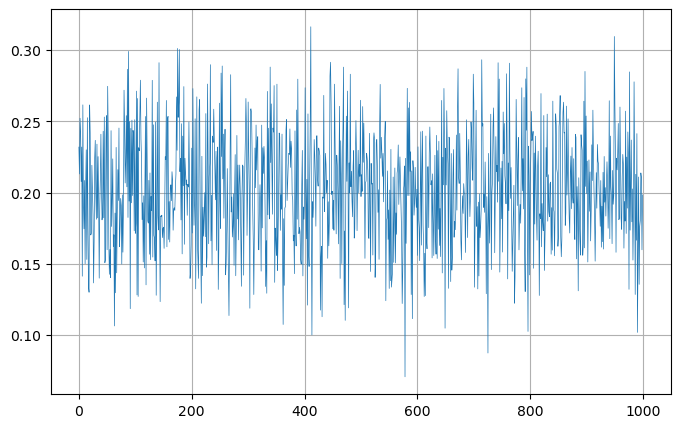

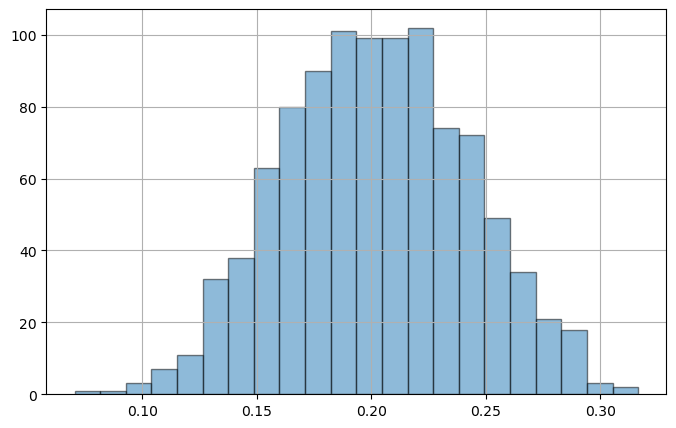

In [71]:
#rng = np.random.default_rng()
mean,unc =.2, .2

if mean!=0:
    scale = mean*unc
else:
    scale = mean+unc
    
samples =  np.random.normal(loc=mean, scale=scale , size=1000)
plt.plot(samples,lw=.5)
plt.grid()
plt.show()
plt.hist(samples, bins='auto', edgecolor='k',alpha=0.5)
plt.grid()
plt.show()

In [33]:
# Cell 1: Imports and STOIIP helper

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make plots a bit larger
plt.rcParams["figure.figsize"] = (8, 5)

def stoiip_stb(area_acres, thickness_ft, porosity, oil_sat, ntg, fvf):
    """
    STOIIP formula in STB.
    STOIIP = 7758 * A(acres) * h(ft) * φ * So * NTG / Bo
    """
    return 7758.0 * area_acres * thickness_ft * porosity * oil_sat * ntg / fvf


In [34]:
# Cell 2: Input means and uncertainties (same names as the app)

area_acres   = 10000.0   # mean area in acres
area_unc     = 10.0      # ±% uncertainty

thickness    = 100.0     # ft
thick_unc    = 15.0      # ±%

porosity     = 0.20      # fraction
por_unc      = 20.0      # ±%

oil_saturation = 0.70    # fraction
sat_unc        = 10.0    # ±%

fvf          = 1.20      # formation volume factor Bo
fvf_unc      = 5.0       # ±%

ntg          = 0.80      # net-to-gross
ntg_unc      = 10.0      # ±%

iterations   = 1000      # Monte Carlo samples


In [35]:
# Cell 3: Generate Monte Carlo samples for each input

rng = np.random.default_rng(1234)  # fixed seed for reproducibility (optional)

# Normal distributions, then clipping to physical limits
area_samples = rng.normal(area_acres,   area_acres   * area_unc/100.0,   iterations)
thick_samples = rng.normal(thickness,   thickness    * thick_unc/100.0,  iterations)
por_samples   = rng.normal(porosity,    porosity     * por_unc/100.0,    iterations)
sat_samples   = rng.normal(oil_saturation, oil_saturation * sat_unc/100.0, iterations)
fvf_samples   = rng.normal(fvf,         fvf          * fvf_unc/100.0,    iterations)
ntg_samples   = rng.normal(ntg,         ntg          * ntg_unc/100.0,    iterations)

# Clip to realistic bounds (same as app)
area_samples  = np.clip(area_samples,  1.0,     None)
thick_samples = np.clip(thick_samples, 1.0,     None)
por_samples   = np.clip(por_samples,   0.05,    0.40)
sat_samples   = np.clip(sat_samples,   0.20,    0.95)
fvf_samples   = np.clip(fvf_samples,   1.0,     2.0)
ntg_samples   = np.clip(ntg_samples,   0.10,    1.0)


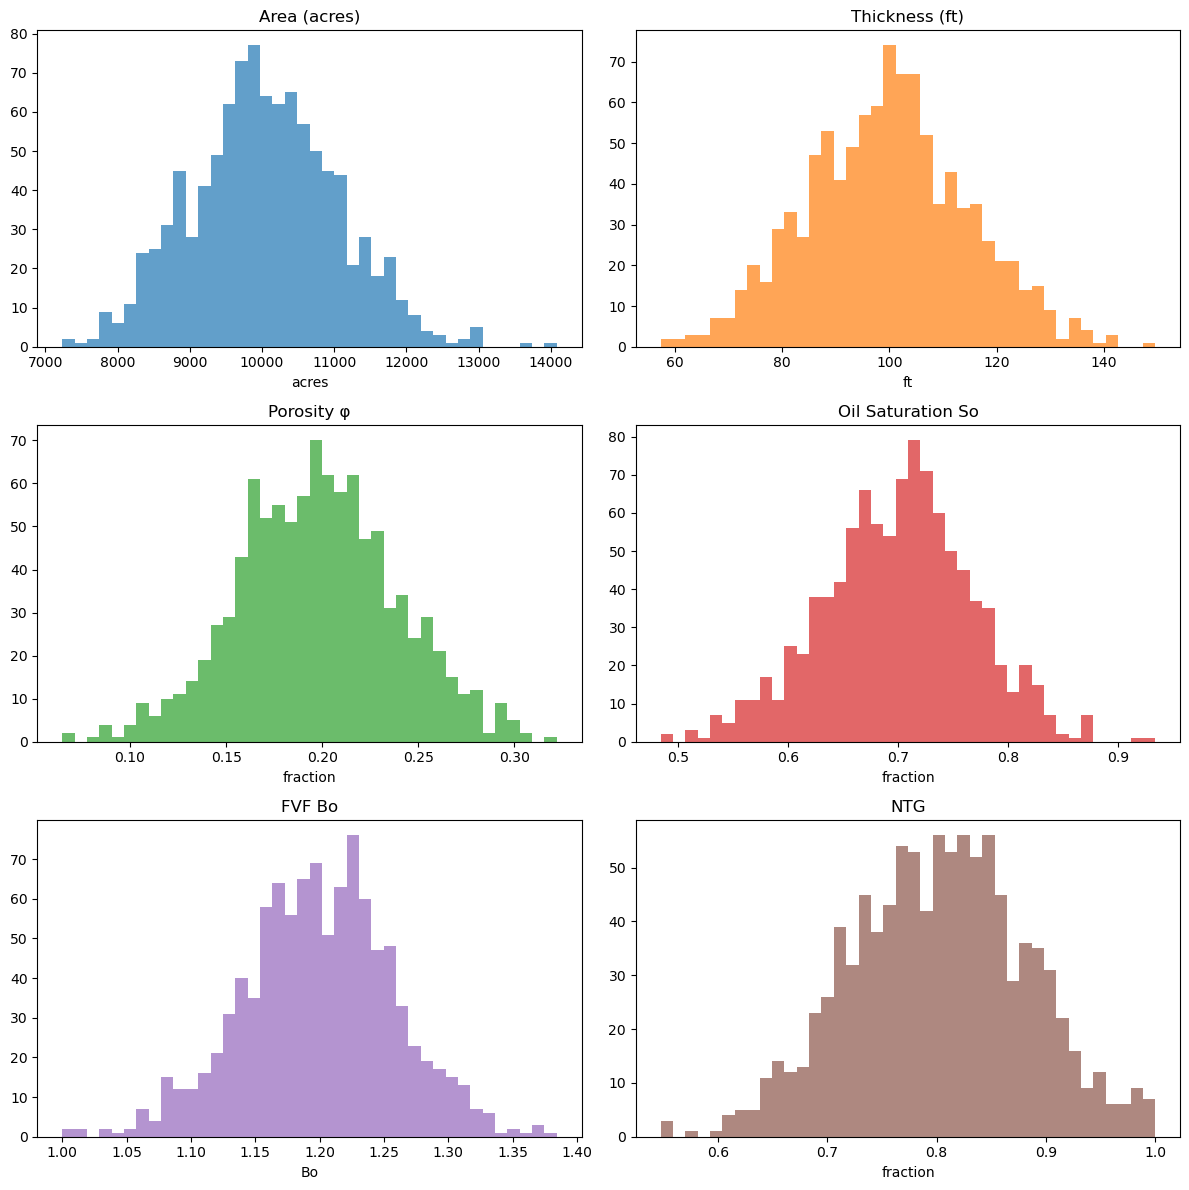

In [36]:
# Cell 4: Histograms of input distributions

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.ravel()

axes[0].hist(area_samples, bins=40, color="C0", alpha=0.7)
axes[0].set_title("Area (acres)")
axes[0].set_xlabel("acres")

axes[1].hist(thick_samples, bins=40, color="C1", alpha=0.7)
axes[1].set_title("Thickness (ft)")
axes[1].set_xlabel("ft")

axes[2].hist(por_samples, bins=40, color="C2", alpha=0.7)
axes[2].set_title("Porosity φ")
axes[2].set_xlabel("fraction")

axes[3].hist(sat_samples, bins=40, color="C3", alpha=0.7)
axes[3].set_title("Oil Saturation So")
axes[3].set_xlabel("fraction")

axes[4].hist(fvf_samples, bins=40, color="C4", alpha=0.7)
axes[4].set_title("FVF Bo")
axes[4].set_xlabel("Bo")

axes[5].hist(ntg_samples, bins=40, color="C5", alpha=0.7)
axes[5].set_title("NTG")
axes[5].set_xlabel("fraction")

plt.tight_layout()
plt.show()


In [ ]:
# Cell 5: STOIIP Monte Carlo and P10/P50/P90

# STOIIP in STB
stoiip_samples_stb = stoiip_stb(
    area_samples,
    thick_samples,
    por_samples,
    sat_samples,
    ntg_samples,
    fvf_samples,
)

# Convert to billions STB (BSTB)
stoiip_samples_bstb = stoiip_samples_stb / 1e9

# Percentiles
p10 = np.percentile(stoiip_samples_bstb, 10)
p50 = np.percentile(stoiip_samples_bstb, 50)
p90 = np.percentile(stoiip_samples_bstb, 90)

print(f"P10 {p10:.3f}, P50 {p50:.3f}, P90 {p90:.3f}")

P10 0.443, P50 0.698, P90 1.019


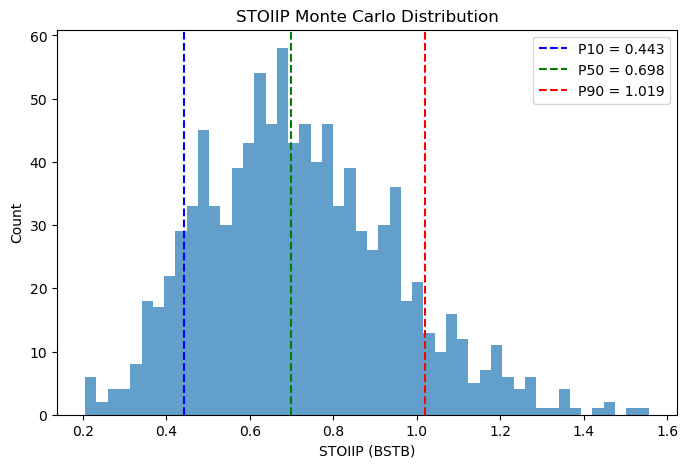

In [ ]:
# Cell 6: STOIIP distribution with P10/P50/P90 lines

plt.figure(figsize=(8, 5))
plt.hist(stoiip_samples_bstb, bins=50, color="C0", alpha=0.7)
plt.axvline(p10, color="blue",  linestyle="--", label=f"P10 = {p10:.3f}")
plt.axvline(p50, color="green", linestyle="--", label=f"P50 = {p50:.3f}")
plt.axvline(p90, color="red",   linestyle="--", label=f"P90 = {p90:.3f}")
plt.xlabel("STOIIP (BSTB)")
plt.ylabel("Count")
plt.title("STOIIP Monte Carlo Distribution")
plt.legend()
plt.show()

In [40]:
# Cell 7: Tornado weights (one-at-a-time std dev)

# Means from the sampled distributions
area_mean  = area_samples.mean()
thick_mean = thick_samples.mean()
por_mean   = por_samples.mean()
sat_mean   = sat_samples.mean()
fvf_mean   = fvf_samples.mean()
ntg_mean   = ntg_samples.mean()

weights = {
    "Area": np.std(
        stoiip_stb(
            area_samples,
            thick_mean,
            por_mean,
            sat_mean,
            ntg_mean,
            fvf_mean,
        )
    ),
    "Thickness": np.std(
        stoiip_stb(
            area_mean,
            thick_samples,
            por_mean,
            sat_mean,
            ntg_mean,
            fvf_mean,
        )
    ),
    "Porosity": np.std(
        stoiip_stb(
            area_mean,
            thick_mean,
            por_samples,
            sat_mean,
            ntg_mean,
            fvf_mean,
        )
    ),
    "Oil Sat": np.std(
        stoiip_stb(
            area_mean,
            thick_mean,
            por_mean,
            sat_samples,
            ntg_mean,
            fvf_mean,
        )
    ),
    "NTG": np.std(
        stoiip_stb(
            area_mean,
            thick_mean,
            por_mean,
            sat_mean,
            ntg_samples,
            fvf_mean,
        )
    ),
    "FVF": np.std(
        stoiip_stb(
            area_mean,
            thick_mean,
            por_mean,
            sat_mean,
            ntg_mean,
            fvf_samples,
        )
    ),
}

total_w = sum(weights.values())
normalized_weights = {k: (v / total_w if total_w > 0 else 0.0) for k, v in weights.items()}

normalized_weights


{'Area': np.float64(0.14293816463888465),
 'Thickness': np.float64(0.21206340041924862),
 'Porosity': np.float64(0.2954033996760357),
 'Oil Sat': np.float64(0.13727472203055144),
 'NTG': np.float64(0.14183149344575954),
 'FVF': np.float64(0.07048881978952011)}

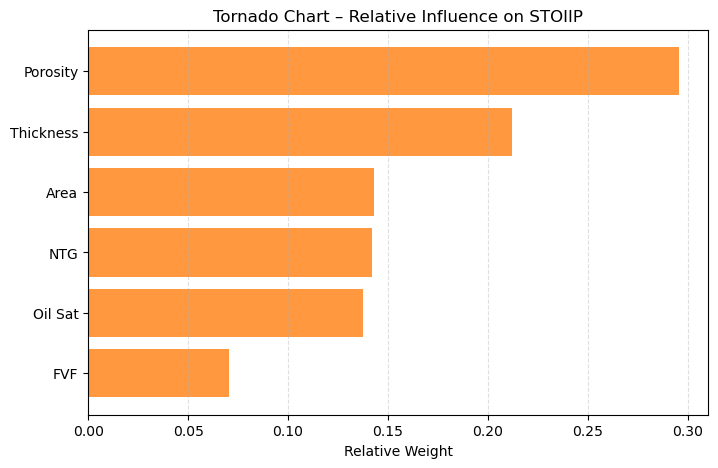

In [41]:
# Cell 8: Tornado (relative weights) bar chart

# Convert to DataFrame and sort
wdf = pd.DataFrame(
    {
        "Variable": list(normalized_weights.keys()),
        "Weight": list(normalized_weights.values()),
    }
).sort_values("Weight", ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(wdf["Variable"], wdf["Weight"], color="C1", alpha=0.8)
plt.xlabel("Relative Weight")
plt.title("Tornado Chart – Relative Influence on STOIIP")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.show()


In [42]:
# Cell 9: Deterministic base STOIIP (using means only) vs P50

stoiip_base_stb = stoiip_stb(
    area_acres,    # original mean inputs (not sample means)
    thickness,
    porosity,
    oil_saturation,
    ntg,
    fvf,
)
stoiip_base_bstb = stoiip_base_stb / 1e9

print(f"Deterministic STOIIP (using input means): {stoiip_base_bstb:,.3f} BSTB")
print(f"Monte Carlo P50:                           {p50:,.3f} BSTB")
print(f"Difference (P50 - deterministic):         {p50 - stoiip_base_bstb:,.3f} BSTB")


Deterministic STOIIP (using input means): 0.724 BSTB
Monte Carlo P50:                           0.698 BSTB
Difference (P50 - deterministic):         -0.026 BSTB


In [43]:
# Cell 10: Sensitivity of STOIIP std to porosity uncertainty

por_unc_grid = np.linspace(0.0, 40.0, 9)  # from 0% to 40% in 5% steps
stoiip_std_list = []

for por_unc_test in por_unc_grid:
    # sample only porosity with changing uncertainty
    por_s_test = rng.normal(
        porosity,
        porosity * por_unc_test / 100.0,
        iterations
    )
    por_s_test = np.clip(por_s_test, 0.05, 0.40)
    
    # keep other parameters fixed at their mean values
    stoiip_stb_test = stoiip_stb(
        area_acres,
        thickness,
        por_s_test,
        oil_saturation,
        ntg,
        fvf,
    )
    stoiip_bstb_test = stoiip_stb_test / 1e9
    stoiip_std_list.append(np.std(stoiip_bstb_test))

por_sens_df = pd.DataFrame({
    "Porosity_unc_%": por_unc_grid,
    "STOIIP_std_BSTB": stoiip_std_list,
})

por_sens_df


,Porosity_unc_%,STOIIP_std_BSTB
0,0.0,2.220446e-16
1,5.0,3.666041e-02
2,10.0,7.460875e-02
3,15.0,1.101746e-01
4,20.0,1.426391e-01
5,25.0,1.787049e-01
6,30.0,2.174609e-01
7,35.0,2.497268e-01
8,40.0,2.701724e-01


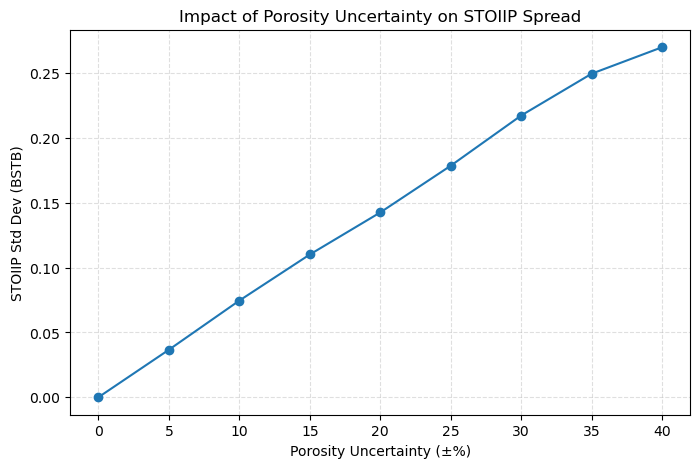

In [44]:
# Cell 11: Plot effect of porosity uncertainty on STOIIP std

plt.figure(figsize=(8, 5))
plt.plot(por_sens_df["Porosity_unc_%"], por_sens_df["STOIIP_std_BSTB"], marker="o")
plt.xlabel("Porosity Uncertainty (±%)")
plt.ylabel("STOIIP Std Dev (BSTB)")
plt.title("Impact of Porosity Uncertainty on STOIIP Spread")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


In [45]:
# Cell 12: Correlation of each input with STOIIP (BSTB)

df_mc = pd.DataFrame({
    "Area": area_samples,
    "Thickness": thick_samples,
    "Porosity": por_samples,
    "OilSat": sat_samples,
    "FVF": fvf_samples,
    "NTG": ntg_samples,
    "STOIIP_BSTB": stoiip_samples_bstb,
})

corr = df_mc.corr()["STOIIP_BSTB"].sort_values(ascending=False)
corr


STOIIP_BSTB    1.000000
Porosity       0.658261
Thickness      0.437020
Area           0.361147
OilSat         0.347095
NTG            0.342677
FVF           -0.102615
Name: STOIIP_BSTB, dtype: float64

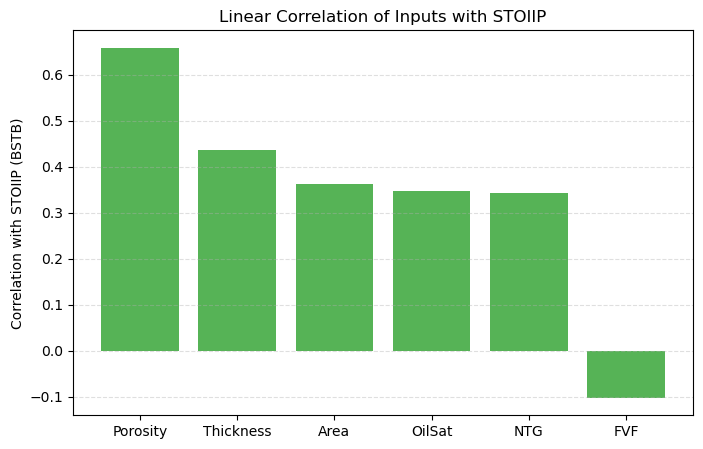

In [46]:
# Cell 13: Bar chart of correlation with STOIIP

corr_inputs = corr.drop("STOIIP_BSTB")  # remove self-correlation

plt.figure(figsize=(8, 5))
plt.bar(corr_inputs.index, corr_inputs.values, color="C2", alpha=0.8)
plt.ylabel("Correlation with STOIIP (BSTB)")
plt.title("Linear Correlation of Inputs with STOIIP")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


In [56]:
print(df_mc.shape)
df_mc.head()

(1000, 7)


,Area,Thickness,Porosity,OilSat,FVF,NTG,STOIIP_BSTB
0,8396.163195,102.021718,0.187357,0.753018,1.249180,0.887931,0.666427
1,10064.099914,113.907227,0.222250,0.653530,1.207127,0.626515,0.670443
2,10740.891296,114.976348,0.200782,0.729520,1.336302,0.806937,0.847415
3,10152.619194,99.911473,0.196580,0.653096,1.139089,0.816766,0.724437
4,10863.743891,98.788582,0.219490,0.711649,1.212457,0.880656,0.944617


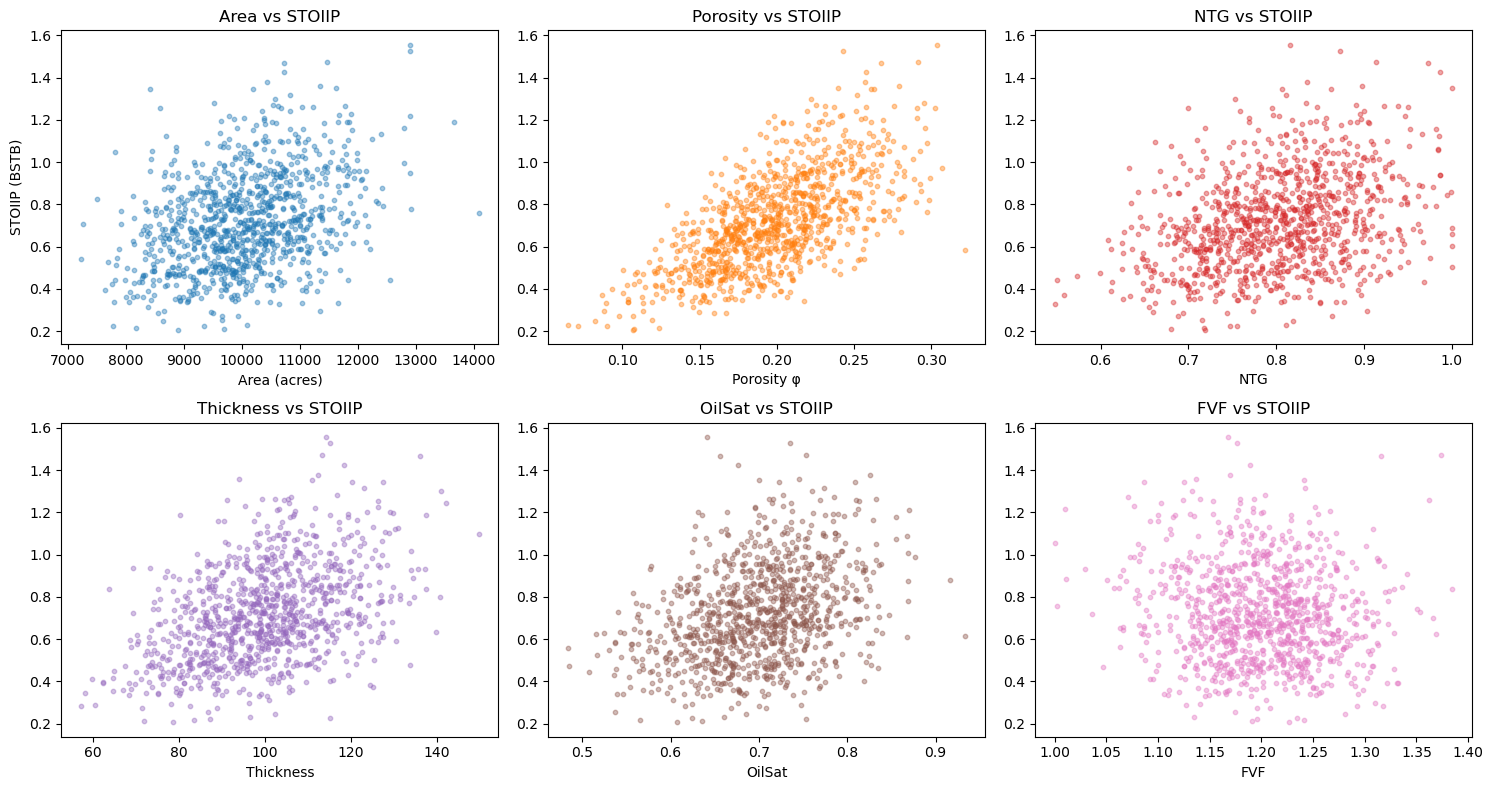

In [54]:
# Cell 14: Example scatter plots (input vs STOIIP)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

axes[0,0].scatter(df_mc["Area"], df_mc["STOIIP_BSTB"], s=10, alpha=0.4)
axes[0,0].set_xlabel("Area (acres)")
axes[0,0].set_ylabel("STOIIP (BSTB)")
axes[0,0].set_title("Area vs STOIIP")

axes[0,1].scatter(df_mc["Porosity"], df_mc["STOIIP_BSTB"], s=10, alpha=0.4, color="C1")
axes[0,1].set_xlabel("Porosity φ")
axes[0,1].set_title("Porosity vs STOIIP")

axes[0,2].scatter(df_mc["NTG"], df_mc["STOIIP_BSTB"], s=10, alpha=0.4, color="C3")
axes[0,2].set_xlabel("NTG")
axes[0,2].set_title("NTG vs STOIIP")

axes[1,0].scatter(df_mc["Thickness"], df_mc["STOIIP_BSTB"], s=10, alpha=0.4, color="C4")
axes[1,0].set_xlabel("Thickness")
axes[1,0].set_title("Thickness vs STOIIP")

axes[1,1].scatter(df_mc["OilSat"], df_mc["STOIIP_BSTB"], s=10, alpha=0.4, color="C5")
axes[1,1].set_xlabel("OilSat")
axes[1,1].set_title("OilSat vs STOIIP")

axes[1,2].scatter(df_mc["FVF"], df_mc["STOIIP_BSTB"], s=10, alpha=0.4, color="C6")
axes[1,2].set_xlabel("FVF")
axes[1,2].set_title("FVF vs STOIIP")

plt.tight_layout()
plt.show()
